# Tasca 7 : Transformació Registre Log amb Regular expressions


L'anàlisi de registres és una funció important per al control i l'alerta, el compliment de les polítiques de seguretat, l'auditoria i el compliment normatiu, la resposta a incidents de seguretat i fins i tot les investigacions forenses. En analitzar les dades de registre, les empreses poden identificar més fàcilment les possibles amenaces i altres problemes, trobar la causa arrel i iniciar una resposta ràpida per mitigar els riscos.

- [Exercici 1](#Exercici1)  
- [Exercici 2](#Exercici2)    
- [Exercici 3](#Exercici3)  
- [Exercici 4](#Exercici4)

## Nivell 1
L'analista ha d'assegurar-se que els registres consisteixen en una gamma completa de missatges i s'interpreten segons el context. Els elements de registre han de normalitzar-se, utilitzant els mateixos termes o terminologia, per evitar confusions i proporcionar cohesió.

Com Científic de Dades se t'ha proporcionat accés als registres-Logs on queda registrada l'activitat de totes les visites a realitzades a la pàgina web de l'agència de viatges "akumenius.com".

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter


import requests
import json
import re

from tqdm import tqdm, notebook

import warnings
warnings.simplefilter('ignore')

In [2]:
file = '../data-sources/Web_access_log-akumenius.com.txt'

f = open(file, 'r')
lines = []
for i in range(30):
    lines.append(f.readline())

# print(f.readlines(356))

f.close()

### Funcions auxiliars

In [3]:
def plot_top(kind, data, x, y, top=5, others=True, **params):
    data = data[y].value_counts().reset_index()
    val_others = data[top:][y].sum()
    dades = data[:top]

    if others:
        dades = pd.concat((dades,pd.DataFrame({x:'Altres', y:val_others}, index=[top+1])), axis=0)
    
    g = kind(data=dades, x=x, y=y, **params)
    return g
    

<a id='Exercici1'></a>
### Exercici 1
Normalitza, identifica i enumera cada un dels atributs / variables de l'estructura de l'arxiu "Web_access_log-akumenius.com" que trobaràs al repositori de GitHub "Data-sources".

[format dels logs Apache](http://httpd.apache.org/docs/1.3/logs.html)

La solució proposada [aquí -stackoverflow-](https://stackoverflow.com/questions/12544510/parsing-apache-log-files) sembla un bon començament

**<font color='#FE2712'>hostname</font> 
<font color='#FC600A'>ip</font> 
<font color='#FB9902'>remote_log_name</font> 
<font color='#FCCC1A'>userid</font>** 
[<font color='#66B032'>**date timezone**</font>] 
"<font color='#347C98'>**request_method**</font>
<font color='#FF0080'>**path**</font> 
_HTTP/_<font color='#0247FE'>**request_version**</font>" 
<font color='#4424D6'>**status**</font>
<font color='#0080FF'>**length**</font> 
"<font color='#8601AF'>**referrer**" </font>
"<font color='#C21460'>**user_agent**" </font> VLOG=-

#### Exemples:
**<font color='#FE2712'>localhost</font> 
<font color='#FC600A'>127.0.0.1</font> 
<font color='#FB9902'>-</font> 
<font color='#FCCC1A'>-</font>** 
[<font color='#66B032'>**23/Feb/2014:03:10:31 +0100**</font>] 
"<font color='347C98'>**OPTIONS**</font> 
<font color='#FF0080'>**\***</font> 
_HTTP/_<font color='#0247FE'>**1.0**</font>" 
<font color='#4424D6'>**200**</font>
<font color='#0080FF'>**-**</font> 
"<font color='#8601AF'>**-**" </font>
"<font color='#C21460'>**Apache (internal dummy connection)**" </font> VLOG=-  

**<font color='#FE2712'>www\.akumenius.com</font> 
<font color='#FC600A'>66.249.76.216</font> 
<font color='#FB9902'>-</font> 
<font color='#FCCC1A'>-</font>** 
[<font color='#66B032'>**23/Feb/2014:03:10:45 +0100**</font>] 
"<font color='#347C98'>**GET**</font>
<font color='#FF0080'>**/hoteles-baratos/ofertas-hotel-Kfar-Giladi-en-Tiberias-121085b-destinos.html**</font> 
_HTTP/_<font color='#0247FE'>**1.1**</font>" 
<font color='#4424D6'>**404**</font>
<font color='#0080FF'>**3100**</font> 
"<font color='#8601AF'>**-**" </font>
"<font color='#C21460'>**Mozilla/5.0 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)**" </font> VLOG=-



##### Provem algunes regular expressions per veure quina ens va millor

In [4]:
ex1 = 'localhost 127.0.0.1 - - [23/Feb/2014:03:10:31 +0100] "OPTIONS * HTTP/1.0" 200 - "-" "Apache (internal dummy connection)" VLOG=-'
ex2 = 'www.akumenius.com 66.249.76.216 - - [23/Feb/2014:03:10:45 +0100] "GET /hoteles-baratos/ofertas-hotel-Kfar-Giladi-en-Tiberias-121085b-destinos.html HTTP/1.1" 404 3100 "-" "Mozilla/5.0 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)" VLOG=-'


In [5]:
re.findall(r'^localhost', ex1)

['localhost']

In [6]:
regex = '([(\d\.)]+) - - \[(.*?)\] "(.*?)" (\d+) - "(.*?)" "(.*?)" (.*?)'
regex2 = '^(?P<hostname>.*?) (?P<ip>[(\d\.)]+) (?P<rem_log>.*?) (?P<userid>.*?) \[(?P<date>.*?)\] "(?P<request>.*?)" (?P<status>\d+) (?P<length>.*?) "(?P<referrer>.*?)" "(?P<user_agent>.*?)" (.*?)'

# from https://stackoverflow.com/questions/40549123/apache-access-log-regex-parsing
regex3 = '(?P<hostname>.*?) (?P<ip>.*?) (?P<remote_log_name>.*?) (?P<userid>.*?) \[(?P<date>.*?)(?= ) (?P<timezone>.*?)\] "(?P<request_method>.*?) (?P<path>.*?) (?P<request_version>HTTP/.*)?" (?P<status>.*?) (?P<length>.*?) \"(?P<referrer>.*?)\" \"(?P<user_agent>.*?)\" '
regex4 = '^([\\d.]+) (\\S+) 3(\\S+) \\[([\\w:/]+\\s[+-]\\d{4})\\] \"(.+?)\" (\\d{3}) (\\d+) \"([^\"]+)\" \"(.+?)\"'

##### regex

In [7]:
print(re.match(regex, ex1))
print(re.match(regex, ex2))

None
None


##### regex2

In [8]:
print(re.match(regex2, ex1).groups())
print(re.match(regex2, ex2).groups())

('localhost', '127.0.0.1', '-', '-', '23/Feb/2014:03:10:31 +0100', 'OPTIONS * HTTP/1.0', '200', '-', '-', 'Apache (internal dummy connection)', '')
('www.akumenius.com', '66.249.76.216', '-', '-', '23/Feb/2014:03:10:45 +0100', 'GET /hoteles-baratos/ofertas-hotel-Kfar-Giladi-en-Tiberias-121085b-destinos.html HTTP/1.1', '404', '3100', '-', 'Mozilla/5.0 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)', '')


##### regex3

In [9]:
print(re.match(regex3, ex1).groups())
print(re.match(regex3, ex2).groups())

('localhost', '127.0.0.1', '-', '-', '23/Feb/2014:03:10:31', '+0100', 'OPTIONS', '*', 'HTTP/1.0', '200', '-', '-', 'Apache (internal dummy connection)')
('www.akumenius.com', '66.249.76.216', '-', '-', '23/Feb/2014:03:10:45', '+0100', 'GET', '/hoteles-baratos/ofertas-hotel-Kfar-Giladi-en-Tiberias-121085b-destinos.html', 'HTTP/1.1', '404', '3100', '-', 'Mozilla/5.0 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)')


##### regex4

In [10]:
print(re.match(regex4, ex1))
print(re.match(regex4, ex2))

None
None


Ens quedarem amb el **regex2** i treballarem després amb les columnes. 

<a id='Exercici2'></a>

## Nivell 2
### Exercici 2
Neteja, preprocesa, estructura i transforma (dataframe) les dades del registre d'Accés a la web.

In [11]:
file = '../data-sources/Web_access_log-akumenius.com.txt'

# f = open(file, 'r')
parsed_lines = []
with open(file, 'r') as lines:
    try:
        while True:
            current = next(lines)
#             print(current)
            parsed_lines.append(re.match(regex2,current).groups())
    except StopIteration:
        print('Acabada la càrrega')

# print(f.readlines(356))

# f.close()
df = pd.DataFrame(parsed_lines)

Acabada la càrrega


In [12]:
df.columns = ['hostname','ip','rem_log_name','userid','date',
              'request','status','length','referrer','user_agent', 'vlog']
df.shape

(261873, 11)

#### Eliminem duplicats

In [13]:
df.drop_duplicates(inplace=True)
df.shape

(257310, 11)

#### Extraiem els method, path i request_method de la columna requests

In [14]:
df[['request_method','path','request_version']] = df.request.str.extract("(?P<request_method>.*?) (?P<path>.*?) (?P<request_version>HTTP/.*)?", )

#### Fem un split del path

In [15]:
df['path_split'] = df.path.str.split('/')

#### Generem el camp de data com a datetime

In [16]:
df['data'] = pd.to_datetime(df.date, format='%d/%b/%Y:%X %z')

<a id='Exercici3'></a>

### Exercici 3
Geolocalitza les IP's. Aqui tens una pagina de interes :IP2Locattion: https://blog.ip2location.com/knowledge-base/how-to-add-a-sub-account-in-ip2location/

### GEO IP 

Busquem la geolocalització de les IP

res = requests.get('https://freegeoip.app/json/66.249.76.216')



In [17]:
df.ip.unique()[:20]

array(['127.0.0.1', '66.249.76.216', '5.255.253.53', '157.55.35.112',
       '193.111.141.116', '5.10.83.71', '180.76.5.223', '180.76.6.148',
       '180.76.5.188', '180.76.6.135', '180.76.6.44', '180.76.5.172',
       '180.76.5.18', '157.56.92.174', '74.86.158.107', '180.76.6.136',
       '5.10.83.87', '5.10.83.21', '5.10.83.31', '180.76.5.64'],
      dtype=object)

#### freegeoip

In [18]:
res = requests.get('https://freegeoip.app/json/83.45.86.81')
res.json()

{'ip': '83.45.86.81',
 'country_code': 'ES',
 'country_name': 'Spain',
 'region_code': 'CT',
 'region_name': 'Catalonia',
 'city': 'Olot',
 'zip_code': '17800',
 'time_zone': 'Europe/Madrid',
 'latitude': 42.181,
 'longitude': 2.4901,
 'metro_code': 0}

In [19]:

# resultats = []

# for ip in tqdm(df.ip.unique()):
#     resultats.append(requests.get(f'https://freegeoip.app/json/{ip}').json())
    
# localitzacions = pd.DataFrame(resultats)

# localitzacions.to_pickle('../data/loc_geoip.pickle')

In [20]:
localitzacions = pd.read_pickle('../data/loc_geoip.pickle')

In [21]:
localitzacions.head()

,ip,country_code,country_name,region_code,region_name,city,zip_code,time_zone,latitude,longitude,metro_code
0,127.0.0.1,,,,,,,,0.0000,0.0000,0
1,66.249.76.216,US,United States,,,,,America/Chicago,37.7510,-97.8220,0
2,5.255.253.53,RU,Russia,MOW,Moscow,Moscow,125009,Europe/Moscow,55.7527,37.6172,0
3,157.55.35.112,US,United States,WA,Washington,,,America/Los_Angeles,47.6032,-122.3412,0
4,193.111.141.116,DE,Germany,NW,North Rhine-Westphalia,Düsseldorf,40472,Europe/Berlin,51.2705,6.8144,0


In [22]:
localitzacions.isna().sum(axis=0)

ip              0
country_code    0
country_name    0
region_code     0
region_name     0
city            0
zip_code        0
time_zone       0
latitude        0
longitude       0
metro_code      0
dtype: int64

#### ip2geotools

In [23]:
from ip2geotools.databases.noncommercial import DbIpCity

ips = df.ip.unique().tolist()
ips.remove('127.0.0.1')
print(ips[:10])
resultats = []
processed = list(pd.read_pickle('../tmp/tmp_processed.pickle').to_dict()[0].values())

['66.249.76.216', '5.255.253.53', '157.55.35.112', '193.111.141.116', '5.10.83.71', '180.76.5.223', '180.76.6.148', '180.76.5.188', '180.76.6.135', '180.76.6.44']


In [24]:
# not_proc = [ip for ip in ips if ip not in processed]

# for ip in tqdm(not_proc):
#     resultats.append(DbIpCity.get(ip, api_key='free').to_json())
#     processed.append(ip)

In [25]:
len(processed)

2044

In [26]:
# GEOLITE
# estic bloquejat en el servei
# resultats = []

# for ip in tqdm(df.ip.unique()):
#     resultats.append(requests.get(f'http://www.geoplugin.net/json.gp?ip={ip}').json())
    
# localitzacions2 = pd.DataFrame(resultats)

In [27]:
# pd.DataFrame(processed).to_pickle('../tmp/tmp_processed.pickle')

### Localitzacions

In [28]:
localitzacions.country_code.nunique()

64

In [29]:
localitzacions.shape

(2921, 11)

Text(0.5, 1.0, 'Top-5 Països')

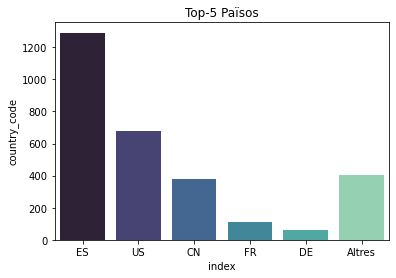

In [30]:
g = plot_top(sns.barplot, data=localitzacions, x='index', y='country_code', palette='mako')
g.set_title('Top-5 Països')

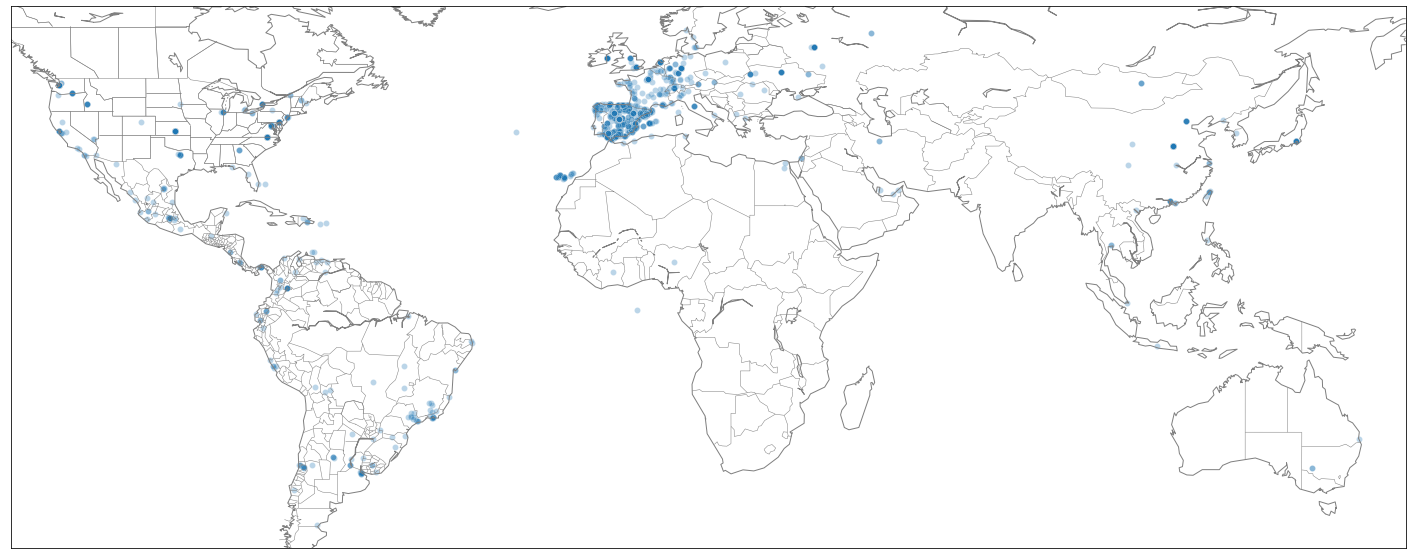

In [31]:
from mpl_toolkits.basemap import Basemap


plt.figure(figsize=(25,20))

m = Basemap(llcrnrlon=localitzacions.longitude.min()-10, llcrnrlat=localitzacions.latitude.min()-5,
            urcrnrlon=localitzacions.longitude.max()+10, urcrnrlat=localitzacions.latitude.max()+5,)
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

g = sns.scatterplot(data=localitzacions, x='longitude', y='latitude', alpha=0.3)

<AxesSubplot:xlabel='index', ylabel='country_code'>

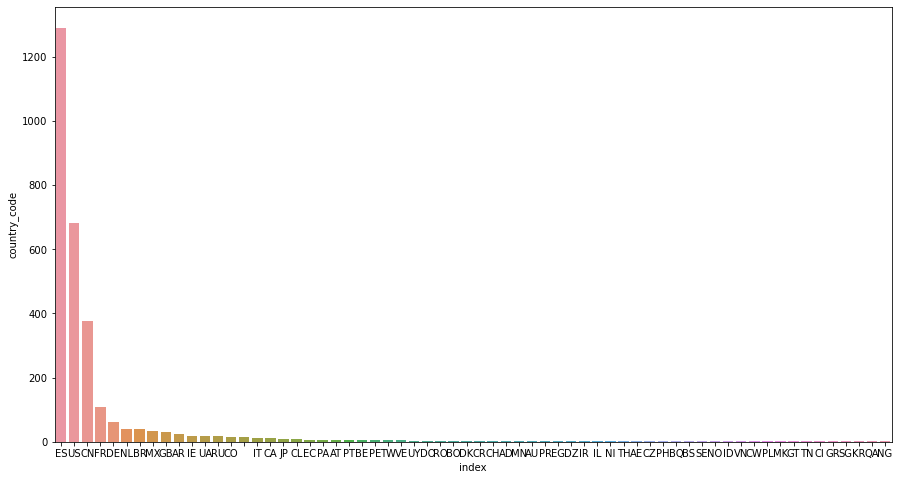

In [32]:
plt.figure(figsize=(15,8))
sns.barplot(data=localitzacions.country_code.value_counts().reset_index(), x='index',y='country_code')

In [33]:
localitzacions.country_code.value_counts()

ES    1291
US     681
CN     377
FR     109
DE      61
      ... 
GR       1
SG       1
KR       1
QA       1
NG       1
Name: country_code, Length: 64, dtype: int64

Text(0.5, 1.0, 'Top 5 Països')

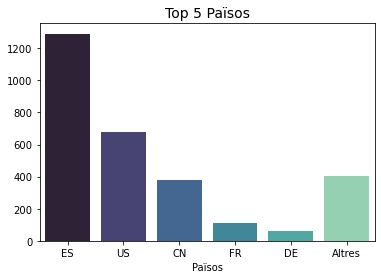

In [34]:

    
g = plot_top(sns.barplot, data=localitzacions, x='index', y='country_code', 
            palette='mako')
g.set_xlabel('Països',)
g.set_ylabel('')
g.set_title('Top 5 Països', size=14)

In [35]:
# # check for duplicated
# mask = (df.request_method != 'OPTIONS')
# df[mask][df[mask][['hostname','ip','rem_log_name','userid','data','request','status','length','referrer','user_agent', 'vlog']].duplicated()]

<a id='Exercici4'></a>
### Exercici 4
Mostreu-me la teva creativitat, Sorprèn-me fes un pas més enllà amb el analysis anterior.

### USER AGENT Parsing

#### ua_parser

In [36]:
from ua_parser import user_agent_parser

ua_parser = pd.json_normalize(df.user_agent.apply(lambda x: user_agent_parser.Parse(x)), sep='_')

In [37]:
ua_parser.user_agent_family.value_counts().reset_index()

,index,user_agent_family
0,Googlebot,51739
1,Chrome,39075
2,Firefox,33947
3,IE,32487
4,Android,20848
...,...,...
88,Galeon,1
89,Yahoo! Slurp,1
90,Mediapartners-Google,1
91,Maxthon,1


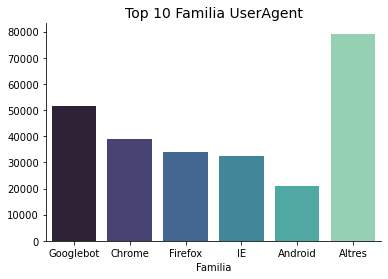

In [38]:

g = plot_top(sns.barplot, ua_parser, x='index',y='user_agent_family', top=5, palette='mako')
g.set_xlabel('Familia',)
g.set_ylabel('')
g.set_title('Top 10 Familia UserAgent', size=14)
sns.despine()


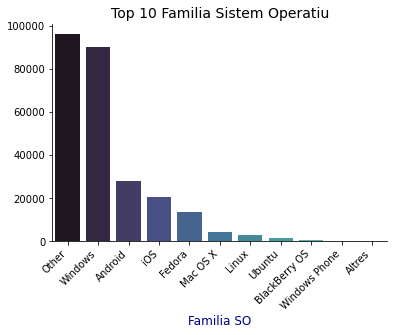

In [39]:
g = plot_top(sns.barplot, ua_parser, x='index',y='os_family', top=10, palette='mako')
g.set_xlabel('Familia SO' , fontdict={'fontsize':12, 'color':'darkblue'})
g.set_ylabel('')
g.set_title('Top 10 Familia Sistem Operatiu', size=14)

# plt.xticks(rotation=45, horizontalalignment='right')
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')

sns.despine()



Text(0.5, 1.0, 'Familia UA per a SO (Other). Bots?')

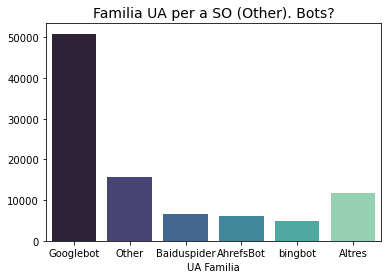

In [40]:
g = plot_top(sns.barplot, ua_parser[ua_parser.os_family == 'Other'], x='index', y='user_agent_family', palette='mako')
g.set_xlabel('UA Familia' )
g.set_ylabel('')
g.set_title('Familia UA per a SO (Other). Bots?', size=14)

In [41]:
ua_parser.head()

,string,user_agent_family,user_agent_major,user_agent_minor,user_agent_patch,os_family,os_major,os_minor,os_patch,os_patch_minor,device_family,device_brand,device_model
0,Apache (internal dummy connection),Other,None,None,None,Other,None,None,None,None,Other,None,None
1,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,Googlebot,2,1,None,Other,None,None,None,None,Spider,Spider,Desktop
2,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,Googlebot,2,1,None,Other,None,None,None,None,Spider,Spider,Desktop
3,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,Googlebot,2,1,None,Other,None,None,None,None,Spider,Spider,Desktop
4,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,Googlebot,2,1,None,Other,None,None,None,None,Spider,Spider,Desktop


In [86]:
user_agent_parser.Parse(df.user_agent[135546], )

{'user_agent': {'family': 'Chrome',
  'major': '33',
  'minor': '0',
  'patch': '1750'},
 'os': {'family': 'Windows',
  'major': 'Vista',
  'minor': None,
  'patch': None,
  'patch_minor': None},
 'device': {'family': 'Other', 'brand': None, 'model': None},
 'string': 'Mozilla/5.0 (Windows NT 6.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/33.0.1750.117 Safari/537.36'}

#### DeviceDetector

In [43]:
from device_detector import DeviceDetector

In [82]:
DeviceDetector(df.user_agent[135546]).parse().all_details

{'bot': {},
 'normalized': '',
 'os': {'name': 'Windows',
  'version': 'Vista',
  'type': 'os',
  'short_name': 'WIN',
  'family': 'Windows',
  'platform': ''},
 'client': {'name': 'Chrome',
  'version': '33.0.1750.117',
  'engine': {'default': 'WebKit', 'versions': {28: 'Blink'}},
  'type': 'browser',
  'short_name': 'CH',
  'app_id': ''}}

In [85]:
df.iloc[135546].user_agent

'Mozilla/5.0 (Windows NT 6.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/33.0.1750.117 Safari/537.36'

In [45]:
DeviceDetector(df.user_agent[135522]).parse()

DeviceDetector(Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 6.0))

In [46]:
(df.user_agent[133120:133166].apply(lambda x: DeviceDetector(x).parse().all_details)).values[1]

{'bot': {'name': 'Googlebot',
  'category': 'Search bot',
  'url': 'http://www.google.com/bot.html',
  'producer': {'name': 'Google Inc.', 'url': 'http://www.google.com'},
  'type': 'bot'}}

In [47]:
df.user_agent[133120:133166].apply(lambda x: DeviceDetector(x).parse().all_details)

135513    {'bot': {'name': 'Googlebot', 'category': 'Sea...
135514    {'bot': {'name': 'Googlebot', 'category': 'Sea...
135515    {'bot': {'name': 'aHrefs Bot', 'category': 'Cr...
135516    {'bot': {'name': 'Googlebot', 'category': 'Sea...
135517    {'bot': {'name': 'Googlebot', 'category': 'Sea...
135518    {'bot': {'name': 'Googlebot', 'category': 'Sea...
135519    {'bot': {'name': 'Googlebot', 'category': 'Sea...
135520    {'bot': {'name': 'Googlebot', 'category': 'Sea...
135521    {'bot': {'name': 'aHrefs Bot', 'category': 'Cr...
135522    {'bot': {}, 'normalized': '', 'os': {'name': '...
135523    {'bot': {'name': 'aHrefs Bot', 'category': 'Cr...
135524    {'bot': {'name': 'Googlebot', 'category': 'Sea...
135525    {'bot': {'name': 'Googlebot', 'category': 'Sea...
135526    {'bot': {'name': 'BingBot', 'category': 'Searc...
135527    {'bot': {'name': 'Googlebot', 'category': 'Sea...
135528    {'bot': {'name': 'Googlebot', 'category': 'Sea...
135529    {'bot': {'name': 'Googlebot', 

In [48]:
for i in range(135513,135540):
    print(DeviceDetector(df.loc[i].user_agent).parse().all_details)

{'bot': {'name': 'Googlebot', 'category': 'Search bot', 'url': 'http://www.google.com/bot.html', 'producer': {'name': 'Google Inc.', 'url': 'http://www.google.com'}, 'type': 'bot'}}
{'bot': {'name': 'Googlebot', 'category': 'Search bot', 'url': 'http://www.google.com/bot.html', 'producer': {'name': 'Google Inc.', 'url': 'http://www.google.com'}, 'type': 'bot'}}
{'bot': {'name': 'aHrefs Bot', 'category': 'Crawler', 'url': 'http://ahrefs.com/robot', 'producer': {'name': 'Ahrefs Pte Ltd', 'url': 'http://ahrefs.com/robot'}, 'type': 'bot'}}
{'bot': {'name': 'Googlebot', 'category': 'Search bot', 'url': 'http://www.google.com/bot.html', 'producer': {'name': 'Google Inc.', 'url': 'http://www.google.com'}, 'type': 'bot'}}
{'bot': {'name': 'Googlebot', 'category': 'Search bot', 'url': 'http://www.google.com/bot.html', 'producer': {'name': 'Google Inc.', 'url': 'http://www.google.com'}, 'type': 'bot'}}
{'bot': {'name': 'Googlebot', 'category': 'Search bot', 'url': 'http://www.google.com/bot.html

In [49]:
from device_detector import DeviceDetector

ua = 'Mozilla/5.0 (Linux; Android 4.3; C5502 Build/10.4.1.B.0.101) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/33.0.1750.136 Mobile Safari/537.36'

# Parse UA string and load data to dict of 'os', 'client', 'device' keys
device = DeviceDetector(ua).parse()

# Use helper methods to extract data by attribute

device.is_bot()      # >>> False

device.os_name()     # >>> Android
device.os_version()  # >>> 4.3
device.engine()      # >>> WebKit

device.device_brand_name()  # >>> Sony
device.device_brand()       # >>> SO
device.device_model()       # >>> Xperia ZR
device.device_type()        # >>> smartphone

# For much faster performance, skip Bot and Device Hardware Detection
# and extract get OS / App details only.
from device_detector import SoftwareDetector

ua = 'Mozilla/5.0 (Linux; Android 6.0; 4Good Light A103 Build/MRA58K) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.83 Mobile Safari/537.36'
device = SoftwareDetector(ua).parse()

device.client_name()        # >>> Chrome Mobile
device.client_short_name()  # >>> CM
device.client_type()        # >>> browser
device.client_version()     # >>> 58.0.3029.83

device.os_name()     # >>> Android
device.os_version()  # >>> 6.0
device.engine()      # >>> WebKit

device.device_brand_name()  # >>> ''
device.device_brand()       # >>> ''
device.device_model()       # >>> ''
device.device_type()        # >>> ''

# Many mobile browser UA strings contain the app info of the APP that's using the browser 
ua = 'Mozilla/5.0 (iPhone; CPU iPhone OS 12_1_4 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Mobile/16D57 EtsyInc/5.22 rv:52200.62.0'
device = DeviceDetector(ua).parse()

device.secondary_client_name()     # >>> EtsyInc
device.secondary_client_type()     # >>> generic
device.secondary_client_version()  # >>> 5.22

'5.22'

### Date 

In [50]:
df.reset_index().set_index('data')

,index,hostname,ip,rem_log_name,userid,date,request,status,length,referrer,user_agent,vlog,request_method,path,request_version,path_split
data,,,,,,,,,,,,,,,,
2014-02-23 03:10:31+01:00,0,localhost,127.0.0.1,-,-,23/Feb/2014:03:10:31 +0100,OPTIONS * HTTP/1.0,200,-,-,Apache (internal dummy connection),,OPTIONS,*,HTTP/1.0,[*]
2014-02-23 03:10:31+01:00,22,www.akumenius.com,66.249.76.216,-,-,23/Feb/2014:03:10:31 +0100,GET /hoteles-baratos/ofertas-hotel-Club-&-Hote...,404,3100,-,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,,GET,/hoteles-baratos/ofertas-hotel-Club-&-Hotel-Le...,HTTP/1.1,"[, hoteles-baratos, ofertas-hotel-Club-&-Hotel..."
2014-02-23 03:10:33+01:00,23,www.akumenius.com,66.249.76.216,-,-,23/Feb/2014:03:10:33 +0100,GET /hoteles-baratos/ofertas-hotel-Metropolis-...,404,3100,-,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,,GET,/hoteles-baratos/ofertas-hotel-Metropolis-Hote...,HTTP/1.1,"[, hoteles-baratos, ofertas-hotel-Metropolis-H..."
2014-02-23 03:10:35+01:00,24,www.akumenius.com,66.249.76.216,-,-,23/Feb/2014:03:10:35 +0100,GET /hoteles-baratos/ofertas-hotel-Faena-Hotel...,404,3100,-,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,,GET,/hoteles-baratos/ofertas-hotel-Faena-Hotel-Bue...,HTTP/1.1,"[, hoteles-baratos, ofertas-hotel-Faena-Hotel-..."
2014-02-23 03:10:38+01:00,25,www.akumenius.com,66.249.76.216,-,-,23/Feb/2014:03:10:38 +0100,GET /hoteles-baratos/ofertas-hotel-Kensington-...,404,3100,-,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,,GET,/hoteles-baratos/ofertas-hotel-Kensington-Town...,HTTP/1.1,"[, hoteles-baratos, ofertas-hotel-Kensington-T..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-03-02 03:05:34+01:00,261866,www.akumenius.com,5.255.253.53,-,-,02/Mar/2014:03:05:34 +0100,GET / HTTP/1.1,200,7528,-,Mozilla/5.0 (compatible; YandexBot/3.0; +http:...,,GET,/,HTTP/1.1,"[, ]"
2014-03-02 03:05:35+01:00,261867,akumenius.es,5.255.253.53,-,-,02/Mar/2014:03:05:35 +0100,GET / HTTP/1.1,301,304,-,Mozilla/5.0 (compatible; YandexBot/3.0; +http:...,,GET,/,HTTP/1.1,"[, ]"
2014-03-02 03:05:39+01:00,261868,www.akumenius.com,5.255.253.53,-,-,02/Mar/2014:03:05:39 +0100,GET / HTTP/1.1,200,7528,-,Mozilla/5.0 (compatible; YandexBot/3.0; +http:...,,GET,/,HTTP/1.1,"[, ]"


In [52]:
df.reset_index().set_index('data',inplace=True)

In [53]:
df.index = pd.DatetimeIndex(df.data.dt.strftime('%Y-%m-%d %H:%M:%S'))

In [54]:
df.drop(columns='data', inplace=True)

In [55]:
df.groupby([pd.Grouper(freq='D'),'status']).count()

hostname     ip  rem_log_name  userid   date  request  \
data       status                                                          
2014-02-23 200        33762  33762         33762   33762  33762    33762   
           206            9      9             9       9      9        9   
           301           80     80            80      80     80       80   
           304          330    330           330     330    330      330   
           400            1      1             1       1      1        1   
...                     ...    ...           ...     ...    ...      ...   
2014-03-02 200         1305   1305          1305    1305   1305     1305   
           206            3      3             3       3      3        3   
           301           12     12            12      12     12       12   
           304           34     34            34      34     34       34   
           403            6      6             6       6      6        6   

                   length  referrer  user_agent   vlog  request_method   path  \
data       status                                                               
2014-02-23 200      33762     33762       33762  33762           33762  33762   
           206          9         9           9      9               9      9   
           301         80        80          80     80              80     80   
           304        330       330         330    330             330    330   
           400          1         1           1      1               1      1   
...                   ...       ...         ...    ...             ...    ...   
2014-03-02 200       1305      1305        1305   1305            1305   1305   
           206          3         3           3      3               3      3   
           301         12        12          12     12              12     12   
           304         34        34          34     34              34     34   
           403          6         6           6      6               6      6   

                   request_version  path_split  
data       status                               
2014-02-23 200               33762       33762  
           206                   9           9  
           301                  80          80  
           304                 330         330  
           400                   1           1  
...                            ...         ...  
2014-03-02 200                1305        1305  
           206                   3           3  
           301                  12          12  
           304                  34          34  
           403                   6           6  

[79 rows x 14 columns]

In [56]:
day_group = pd.Grouper(freq='D')

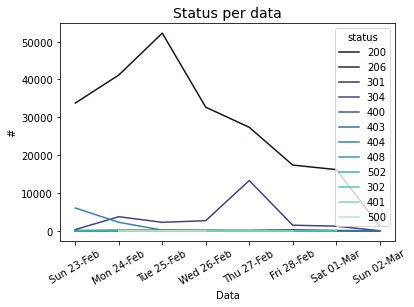

In [79]:
data = df.groupby([day_group,'status'])['ip'].count().reset_index()
g = sns.lineplot(data=data, x='data',y='ip', hue='status',
                palette='mako')

date_form = DateFormatter("%a %d-%b")
g.xaxis.set_major_formatter(date_form)
# g.set_xticklabels(g.get_xticklabels(), rotation=45)
g.set_xlabel('Data',)
g.set_ylabel('#')
g.set_title('Status per data', size=14)
ax = plt.xticks(rotation=30)

Text(0, 0.5, 'count (log)')

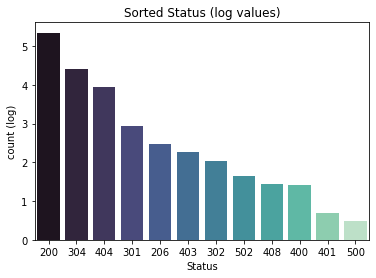

In [81]:
g = sns.barplot(data=np.log10(df.status.value_counts()).reset_index(), x='index',y='status',
               palette='mako')
g.set_title('Sorted Status (log values)')
g.set_xlabel('Status')
g.set_ylabel("count (log)")

### Request methods

In [58]:
df.request_method.value_counts().reset_index()

,index,request_method
0,GET,228776
1,OPTIONS,13868
2,POST,12847
3,HEAD,1787


Text(0.5, 1.0, 'Top 5 Mètodes Request')

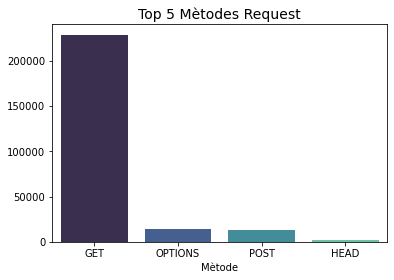

In [59]:
df.request_method.value_counts()
g = plot_top(sns.barplot, data=df, x='index',y='request_method', top=4, others=False,
            palette='mako')
g.set_xlabel('Mètode',)
g.set_ylabel('')
g.set_title('Top 5 Mètodes Request', size=14)


Text(0.5, 1.0, 'Versió HTTP')

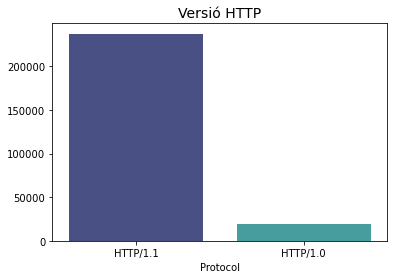

In [73]:
df.request_method.value_counts()
g = plot_top(sns.barplot, data=df, x='index',y='request_version', top=4, others=False,
            palette='mako')
g.set_xlabel('Protocol',)
g.set_ylabel('')
g.set_title('Versió HTTP', size=14)


### Path splitting

In [61]:
# fa un split del path... i genera bastantes columnes... haurem de mirar quines... i per què genera nan i None
df.path.str.split('/', expand=True).rename(columns={i: 'col_' + str(i) for i in range(22)})['col_7'].value_counts()

buscadores                                                                   15963
blocks                                                                        7403
escapadas                                                                     4155
images                                                                        2341
boto_home_reserva.png                                                         1750
                                                                             ...  
fotoEscapadas.JPG                                                                1
2)));%7Delse%7BcenteredY%20=%20window.screenY%20+%20(((window.outerHeight        1
lupa.png                                                                         1
ga.js?_=1393265663555                                                            1
place.png                                                                        1
Name: col_7, Length: 123, dtype: int64

In [65]:
df.tail(40)

,hostname,ip,rem_log_name,userid,date,request,status,length,referrer,user_agent,vlog,request_method,path,request_version,path_split
data,,,,,,,,,,,,,,,
2014-03-02 02:48:09,www.akumenius.com,83.45.25.198,-,-,02/Mar/2014:02:48:09 +0100,GET / HTTP/1.1,200,7528,http://www.akumenius.com/chollos,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:27.0) G...,,GET,/,HTTP/1.1,"[, ]"
2014-03-02 02:48:10,www.akumenius.com,83.45.25.198,-,-,02/Mar/2014:02:48:10 +0100,GET / HTTP/1.1,200,7528,http://www.akumenius.com/chollos,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:27.0) G...,,GET,/,HTTP/1.1,"[, ]"
2014-03-02 02:48:13,www.akumenius.com,83.45.25.198,-,-,02/Mar/2014:02:48:13 +0100,GET /chollos HTTP/1.1,200,7948,http://www.akumenius.com/escapadas,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:27.0) G...,,GET,/chollos,HTTP/1.1,"[, chollos]"
2014-03-02 02:48:14,www.akumenius.com,83.45.25.198,-,-,02/Mar/2014:02:48:14 +0100,GET /chollos HTTP/1.1,200,7948,http://www.akumenius.com/escapadas,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:27.0) G...,,GET,/chollos,HTTP/1.1,"[, chollos]"
2014-03-02 02:48:14,www.akumenius.com,83.45.25.198,-,-,02/Mar/2014:02:48:14 +0100,GET /favicon.ico HTTP/1.1,200,3175,-,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:27.0) G...,,GET,/favicon.ico,HTTP/1.1,"[, favicon.ico]"
2014-03-02 02:48:14,www.akumenius.com,83.45.25.198,-,-,02/Mar/2014:02:48:14 +0100,GET /escapadas HTTP/1.1,200,9547,http://www.akumenius.com/,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:27.0) G...,,GET,/escapadas,HTTP/1.1,"[, escapadas]"
2014-03-02 02:48:15,www.akumenius.com,83.45.25.198,-,-,02/Mar/2014:02:48:15 +0100,GET /favicon.ico HTTP/1.1,200,3175,-,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:27.0) G...,,GET,/favicon.ico,HTTP/1.1,"[, favicon.ico]"
2014-03-02 02:48:51,www.akumenius.com,66.249.76.216,-,-,02/Mar/2014:02:48:51 +0100,GET /destinos-caracteristicas/hoteles-baratos-...,200,6432,-,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,,GET,/destinos-caracteristicas/hoteles-baratos-en-E...,HTTP/1.1,"[, destinos-caracteristicas, hoteles-baratos-e..."
2014-03-02 02:50:01,www.akumenius.com,176.31.255.177,-,-,02/Mar/2014:02:50:01 +0100,GET /hotels-consulted-update HTTP/1.0,200,-,-,Wget/1.12 (linux-gnu),,GET,/hotels-consulted-update,HTTP/1.0,"[, hotels-consulted-update]"


In [66]:
df.user_agent.str.extract('(?P<browser>.*?)[\s+]\((?P<other_info>.*?)\)').browser.unique()

array(['Apache', 'Mozilla/5.0', 'Mozilla/4.0', 'msnbot-media/1.1',
       'Wget/1.12', 'ia_archiver', 'DoCoMo/2.0 N905i(c100;TB;W24H16)',
       'Mozil178.33.117.128, Mozilla/5.0',
       'SAMSUNG-SGH-E250/1.0 Profile/MIDP-2.0 Configuration/CLDC-1.1 UP.Browser/6.2.3.3.c.1.101',
       nan, 'facebookexternalhit/1.1', 'msnbot/2.0b', 'Baiduspider-image',
       'Dalvik/1.6.0', 'Curl/PHP 5.4.16', 'Opera/9.00',
       'LG-E430/Mozilla/5.0', 'Opera/8.00', 'Opera/9.80', 'Mozilla/6.0',
       'AdsBot-Google-Mobile', 'AdsBot-Google', 'Opera/7.54',
       'Mozilla/1.22', 'Google-HTTP-Java-Client/1.17.0-rc',
       'rogerbot/1.0', 'Mozilla/3.0', 'Wget/1.10.2', 'Mozilla/4.7',
       'Mozilla/4.79 [en]', "'Mozilla/5.0", 'LG-E460/Mozilla/5.0',
       'Apache-HttpClient/UNAVAILABLE', 'Apache-HttpClient/4.3',
       'Mozilla/2.0', 'Mozilla/5.0 Galeon/1.0.2'], dtype=object)

In [67]:
df.user_agent.str.extract('(?P<browser>.*?)[\s+]\((?P<other_info>.*?)\)').other_info.str.extract(';(?P<client>.*?);').client.unique()

array([nan, ' Googlebot/2.1', ' YandexBot/3.0', ' bingbot/2.0',
       ' Linux i686', ' AhrefsBot/5.0', ' Baiduspider/2.0',
       ' UptimeRobot/2.0', ' WOW64', ' spbot/4.0.7', ' MSIE 6.0',
       ' MSIE 7.0', ' Googlebot-Mobile/2.1', ' Ezooms/1.0', ' U',
       ' MJ12bot/v1.4.4', ' MSIE 8.0', ' MSIE 5.5', ' YandexImages/3.0',
       ' Android 4.1.2', ' Android 4.3', ' MSIE 10.0', ' BLEXBot/1.0',
       ' MSIE 9.0', ' EasouSpider', ' Win64', ' Trident/7.0', 'U',
       ' Android 4.2.2', ' Ubuntu', ' MSIE 5.01', ' CareerBot/1.1',
       ' Tablet', ' URLAppendBot/1.0', ' Exabot/3.0', ' MSIE 5.0',
       ' socialbm_bot/1.0', ' Android 4.1.1', ' SISTRIX Crawler',
       ' Linux x86_64', ' archive.org_bot',
       ' Opera Mini/7.1.33553/34.1309', ' Intel Mac OS X 10.5',
       ' MSIE 7.0a1', ' Add Catalog/2.1', ' MSIE 2.0', ' SeznamBot/3.2',
       ' TweetmemeBot/3.0', ' PaperLiBot/2.1', ' Intel Mac OS X 10.6',
       ' proximic', 'u', ' Android 4.4.2', ' GrapeshotCrawler/2.0',
       ' mea

In [68]:
df.user_agent.str.extract('(?P<browser>.*?)[\s+]\((?P<other_info>.*?)\)').other_info.value_counts()

compatible; Googlebot/2.1; +http://www.google.com/bot.html    50914
internal dummy connection                                     13868
X11; U; Linux i686; ca; rv:1.9.2.17                           13737
Windows NT 6.1; WOW64                                         13428
Windows NT 6.1                                                 8427
                                                              ...  
compatible; MSIE 6.0; Windows NT 5.1; .NET CLR 1.1.4322           1
Linux; U; Android 2.3.3; es-es; GT-I9100 Build/GINGERBREAD        1
Linux; U; Android 4.3; es-es; SM-N9005 Build/JSS15J               1
Linux; U; Android 4.2.2; es-es; A1-810 Build/JDQ39                1
Windows NT 6.1; WOW64; rv:22.0                                    1
Name: other_info, Length: 599, dtype: int64

In [69]:
df[df.user_agent.str.contains('Chrome')].user_agent.value_counts().sort_values(ascending=False)

Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/33.0.1750.117 Safari/537.36                                  9259
Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/33.0.1750.117 Safari/537.36                                         7605
Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/33.0.1750.117 Safari/537.36                                         6785
Mozilla/5.0 (Windows NT 6.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/33.0.1750.117 Safari/537.36                                  3530
Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.107 Safari/537.36                                  2065
                                                                                                                                               ... 
Mozilla/5.0 (Windows NT 5.1) AppleWebKit/536.5 (KHTML, like Gecko) Chrome/19.0.1084.52 Safari/536.5             

In [70]:
df

,hostname,ip,rem_log_name,userid,date,request,status,length,referrer,user_agent,vlog,request_method,path,request_version,path_split
data,,,,,,,,,,,,,,,
2014-02-23 03:10:31,localhost,127.0.0.1,-,-,23/Feb/2014:03:10:31 +0100,OPTIONS * HTTP/1.0,200,-,-,Apache (internal dummy connection),,OPTIONS,*,HTTP/1.0,[*]
2014-02-23 03:10:31,www.akumenius.com,66.249.76.216,-,-,23/Feb/2014:03:10:31 +0100,GET /hoteles-baratos/ofertas-hotel-Club-&-Hote...,404,3100,-,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,,GET,/hoteles-baratos/ofertas-hotel-Club-&-Hotel-Le...,HTTP/1.1,"[, hoteles-baratos, ofertas-hotel-Club-&-Hotel..."
2014-02-23 03:10:33,www.akumenius.com,66.249.76.216,-,-,23/Feb/2014:03:10:33 +0100,GET /hoteles-baratos/ofertas-hotel-Metropolis-...,404,3100,-,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,,GET,/hoteles-baratos/ofertas-hotel-Metropolis-Hote...,HTTP/1.1,"[, hoteles-baratos, ofertas-hotel-Metropolis-H..."
2014-02-23 03:10:35,www.akumenius.com,66.249.76.216,-,-,23/Feb/2014:03:10:35 +0100,GET /hoteles-baratos/ofertas-hotel-Faena-Hotel...,404,3100,-,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,,GET,/hoteles-baratos/ofertas-hotel-Faena-Hotel-Bue...,HTTP/1.1,"[, hoteles-baratos, ofertas-hotel-Faena-Hotel-..."
2014-02-23 03:10:38,www.akumenius.com,66.249.76.216,-,-,23/Feb/2014:03:10:38 +0100,GET /hoteles-baratos/ofertas-hotel-Kensington-...,404,3100,-,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,,GET,/hoteles-baratos/ofertas-hotel-Kensington-Town...,HTTP/1.1,"[, hoteles-baratos, ofertas-hotel-Kensington-T..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-03-02 03:05:34,www.akumenius.com,5.255.253.53,-,-,02/Mar/2014:03:05:34 +0100,GET / HTTP/1.1,200,7528,-,Mozilla/5.0 (compatible; YandexBot/3.0; +http:...,,GET,/,HTTP/1.1,"[, ]"
2014-03-02 03:05:35,akumenius.es,5.255.253.53,-,-,02/Mar/2014:03:05:35 +0100,GET / HTTP/1.1,301,304,-,Mozilla/5.0 (compatible; YandexBot/3.0; +http:...,,GET,/,HTTP/1.1,"[, ]"
2014-03-02 03:05:39,www.akumenius.com,5.255.253.53,-,-,02/Mar/2014:03:05:39 +0100,GET / HTTP/1.1,200,7528,-,Mozilla/5.0 (compatible; YandexBot/3.0; +http:...,,GET,/,HTTP/1.1,"[, ]"


In [71]:
df.userid.value_counts()

-          257283
clarcat        27
Name: userid, dtype: int64

In [72]:
df.reset_index()['request_method'].value_counts()

GET        228776
OPTIONS     13868
POST        12847
HEAD         1787
Name: request_method, dtype: int64